In [1]:
#SO when you install spark on EMR cluster it comes with hudi already installed but it is local filesystem we need to copy it hdfs file system using the followinnf step after that only we can run it in notebooks
#https://docs.aws.amazon.com/emr/latest/ReleaseGuide/emr-hudi-work-with-dataset.html
#Use Hudi with Amazon EMR Notebooks using Amazon EMR 6.7 and later

# In EC2 master instances 
# Step1 - hdfs dfs -mkdir -p /apps/hudi/lib
# step2 - hdfs dfs -copyFromLocal /usr/lib/hudi/hudi-spark-bundle.jar /apps/hudi/lib/hudi-spark-bundle.jar
# step3 - hdfs dfs -copyFromLocal /usr/lib/spark/external/lib/spark-avro.jar  /apps/hudi/lib/spark-avro.jar

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
1,application_1684296506639_0002,pyspark,idle,Link,Link,None,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
spark

In [2]:
%%configure -f
{ "conf": {
            "spark.jars":"hdfs:///apps/hudi/lib/hudi-spark-bundle.jar",
            "spark.serializer":"org.apache.spark.serializer.KryoSerializer",
            "spark.sql.catalog.spark_catalog": "org.apache.spark.sql.hudi.catalog.HoodieCatalog",
            "spark.sql.extensions":"org.apache.spark.sql.hudi.HoodieSparkSessionExtension"
          }}

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
2,application_1684296506639_0003,pyspark,idle,Link,Link,None,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
2,application_1684296506639_0003,pyspark,idle,Link,Link,None,✔


In [3]:
# General Constants - Basic Configuration
HUDI_FORMAT = "org.apache.hudi"
TABLE_NAME = "hoodie.table.name"
RECORDKEY_FIELD_OPT_KEY = "hoodie.datasource.write.recordkey.field"
PRECOMBINE_FIELD_OPT_KEY = "hoodie.datasource.write.precombine.field"
OPERATION_OPT_KEY = "hoodie.datasource.write.operation"
BULK_INSERT_OPERATION_OPT_VAL = "bulk_insert"
UPSERT_OPERATION_OPT_VAL = "upsert"
BULK_INSERT_PARALLELISM = "hoodie.bulkinsert.shuffle.parallelism"
UPSERT_PARALLELISM = "hoodie.upsert.shuffle.parallelism"
S3_CONSISTENCY_CHECK = "hoodie.consistency.check.enabled"
HUDI_CLEANER_POLICY = "hoodie.cleaner.policy"
KEEP_LATEST_COMMITS = "KEEP_LATEST_COMMITS"
HUDI_COMMITS_RETAINED = "hoodie.cleaner.commits.retained"
PAYLOAD_CLASS_OPT_KEY = "hoodie.datasource.write.payload.class"
EMPTY_PAYLOAD_CLASS_OPT_VAL = "org.apache.hudi.common.model.EmptyHoodieRecordPayload"

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [4]:
# Hive Constants - Needed
HIVE_SYNC_ENABLED_OPT_KEY="hoodie.datasource.hive_sync.enable"
HIVE_PARTITION_FIELDS_OPT_KEY="hoodie.datasource.hive_sync.partition_fields"
HIVE_ASSUME_DATE_PARTITION_OPT_KEY="hoodie.datasource.hive_sync.assume_date_partitioning"
HIVE_PARTITION_EXTRACTOR_CLASS_OPT_KEY="hoodie.datasource.hive_sync.partition_extractor_class"
HIVE_TABLE_OPT_KEY="hoodie.datasource.hive_sync.table"

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [5]:
# Partition Constants - For big dataset 
NONPARTITION_EXTRACTOR_CLASS_OPT_VAL="org.apache.hudi.hive.NonPartitionedExtractor"
MULTIPART_KEYS_EXTRACTOR_CLASS_OPT_VAL="org.apache.hudi.hive.MultiPartKeysValueExtractor"
KEYGENERATOR_CLASS_OPT_KEY="hoodie.datasource.write.keygenerator.class"
NONPARTITIONED_KEYGENERATOR_CLASS_OPT_VAL="org.apache.hudi.keygen.NonpartitionedKeyGenerator"
COMPLEX_KEYGENERATOR_CLASS_OPT_VAL="org.apache.hudi.ComplexKeyGenerator"
PARTITIONPATH_FIELD_OPT_KEY="hoodie.datasource.write.partitionpath.field"

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [6]:
#Incremental Constants
VIEW_TYPE_OPT_KEY="hoodie.datasource.view.type"
BEGIN_INSTANTTIME_OPT_KEY="hoodie.datasource.read.begin.instanttime"
VIEW_TYPE_INCREMENTAL_OPT_VAL="incremental"
END_INSTANTTIME_OPT_KEY="hoodie.datasource.read.end.instanttime"

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [7]:
# Generate Dummy Dataset for testing

from datetime import datetime
dest = ["Seattle", "New York", "New Jersey", "Los Angeles", "Las Vegas", "Tucson","Washington DC","Philadelphia","Miami","San Francisco"]
def get_json_data(start, count, dest):
    time_stamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S.%f')[:-3]
    data = [{"trip_id": i, "ts": time_stamp, "route_id": chr(65 + (i % 10)), "destination": dest[i%10]} for i in range(start, start + count)]
    return data

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [8]:
datetime.now().strftime('%Y-%m-%d %H:%M:%S.%f')[:-3]

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

'2023-05-17 04:18:42.430'

In [9]:
#Create a spark dataframe
def create_json_df(spark, data):
    sc = spark.sparkContext
    return spark.read.json(sc.parallelize(data))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## COW IMPLEMENTATION

In [ ]:
#Inserting dataset of large size
df = create_json_df(spark, get_json_data(0, 2000000, dest))

In [ ]:
df.show(truncate=False)

In [60]:
config = {
    "table_name": "hudi_trips_table",
    "target": "s3://emrpocgigaforce/Output/hudi_data/hudi/",
    "primary_key": "trip_id",
    "sort_key": "ts",
    "commits_to_retain": "2"
}

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
(df.write.format(HUDI_FORMAT)
      .option(PRECOMBINE_FIELD_OPT_KEY,config["sort_key"])
      .option(RECORDKEY_FIELD_OPT_KEY, config["primary_key"])
      .option(TABLE_NAME, config['table_name'])
      .option(OPERATION_OPT_KEY, BULK_INSERT_OPERATION_OPT_VAL)
      .option(BULK_INSERT_PARALLELISM, 3)
      .option(S3_CONSISTENCY_CHECK, "true")
      .option(HIVE_TABLE_OPT_KEY,config['table_name'])
      .option(HIVE_SYNC_ENABLED_OPT_KEY,"true")
      .option(HIVE_PARTITION_EXTRACTOR_CLASS_OPT_KEY,NONPARTITION_EXTRACTOR_CLASS_OPT_VAL)
      .option(KEYGENERATOR_CLASS_OPT_KEY,NONPARTITIONED_KEYGENERATOR_CLASS_OPT_VAL)
      .mode("Overwrite")
      .save(config['target']))

In [ ]:
spark.sql("show tables").show()

In [ ]:
spark.sql("show create table "+config['table_name']).show(truncate=False)

In [ ]:
# Read the table from s3 
df2=spark.read.format(HUDI_FORMAT).load(config["target"]+"/*")

In [ ]:
df2.show()

In [ ]:
df2.printSchema()

In [ ]:
# Batch Upserting the data 
# For this process we need to modify some of the data 
# Modify the data
from pyspark.sql.functions import *
from pyspark.sql.functions import lit
from pyspark.sql.functions import when, col

#check for the data
df2.filter((df2.trip_id>=1000000) & (df2.trip_id<1000100)).show()

In [ ]:
# Changing data for upsert
upsert_dest= ["boston" for i in range (0,100)]

In [ ]:
len(upsert_dest)

In [ ]:
df3=create_json_df(spark, get_json_data(1000000,100, upsert_dest))

In [ ]:
df3.show(truncate=False)

In [ ]:
# ERROR WHILE UPSERTING DATA
# ERROR: The error message `org.apache.hudi.exception.HoodieException: ts(Part -ts) field not found in record. Acceptable fields were` indicates that the timestamp field (by default, "_ts" or "ts") expected by Hudi for maintaining data versioning could not be found in the dataset being written. 
# SOLUTION : This error can occur if the name of the timestamp field in the dataset does not match the default Hudi timestamp field name or if the timestamp field is missing from the dataset.

In [ ]:
#  UPsert the changes in s3 now


(df3.write.format(HUDI_FORMAT)
      .option(RECORDKEY_FIELD_OPT_KEY, config["primary_key"])
      .option(TABLE_NAME, config['table_name'])
      .option(OPERATION_OPT_KEY, UPSERT_OPERATION_OPT_VAL)
      .option(UPSERT_PARALLELISM, 4)
      .option(S3_CONSISTENCY_CHECK, "true")
      .option(HUDI_CLEANER_POLICY, KEEP_LATEST_COMMITS)
      .option(HUDI_COMMITS_RETAINED,config["commits_to_retain"])
      .option(HIVE_TABLE_OPT_KEY,config['table_name'])
      .option(HIVE_SYNC_ENABLED_OPT_KEY,"true")
      .option(HIVE_PARTITION_EXTRACTOR_CLASS_OPT_KEY,NONPARTITION_EXTRACTOR_CLASS_OPT_VAL)
      .option(KEYGENERATOR_CLASS_OPT_KEY,NONPARTITIONED_KEYGENERATOR_CLASS_OPT_VAL)  
      .mode("Append")
      .save(config['target']))

In [ ]:
# Checking the unique commit time
spark.sql("select distinct(_hoodie_commit_time) as commitTime from hudi_trips_table order by commitTime").show(20, False)


In [ ]:
spark.sql("select trip_id, route_id, ts, destination from "+config['table_name'] +" where trip_id between 1000000 and 1000200").show(150,False)

In [61]:
# Inserting new data

insert_dest=["chennai" for i in range(0,100)]
df4=create_json_df(spark,get_json_data(2000000,100,insert_dest))
df4.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Interrupted by user


In [ ]:
#  Insert the changes in s3 now - same config of hudi options as upsert. Since it is new data it will be inserted directly 
(df4.write.format(HUDI_FORMAT)
      .option(RECORDKEY_FIELD_OPT_KEY, config["primary_key"])
      .option(TABLE_NAME, config['table_name'])
      .option(OPERATION_OPT_KEY, UPSERT_OPERATION_OPT_VAL)
      .option(UPSERT_PARALLELISM, 4)
      .option(S3_CONSISTENCY_CHECK, "true")
      .option(HUDI_CLEANER_POLICY, KEEP_LATEST_COMMITS)
      .option(HUDI_COMMITS_RETAINED,config["commits_to_retain"])
      .option(HIVE_TABLE_OPT_KEY,config['table_name'])
      .option(HIVE_SYNC_ENABLED_OPT_KEY,"true")
      .option(HIVE_PARTITION_EXTRACTOR_CLASS_OPT_KEY,NONPARTITION_EXTRACTOR_CLASS_OPT_VAL)
      .option(KEYGENERATOR_CLASS_OPT_KEY,NONPARTITIONED_KEYGENERATOR_CLASS_OPT_VAL)  
      .mode("Append")
      .save(config['target']))

In [ ]:
# Check the data 
spark.sql("select * from " + config['table_name'] +" where trip_id  between 2000000 and 2000100").show(50,False)

#### DELETE
Hudi supports implementing two types of deletes on data stored in Hudi tables, by enabling the user to specify a different record payload implementation.

For delete neither extra file not commit is added 

It can't be rollback since data has been deleted from hudi table

Soft Deletes : Retain the record key and just null out the values for all the other fields. This can be achieved by ensuring the appropriate fields are nullable in the table schema and simply upserting the table after setting these fields to null.

Hard Deletes : A stronger form of deletion is to physically remove any trace of the record from the table. This can be achieved in 3 different ways.

    Using DataSource, set OPERATION_OPT_KEY to DELETE_OPERATION_OPT_VAL. This will remove all the records in the DataSet being submitted.
    Using DataSource, set PAYLOAD_CLASS_OPT_KEY to "org.apache.hudi.EmptyHoodieRecordPayload". This will remove all the records in the DataSet being submitted.
    Using DataSource or DeltaStreamer, add a column named _hoodie_is_deleted to DataSet. The value of this column must be set to true for all the records to be deleted and either false or left null for any records which are to be upserted.

In [ ]:
# Load Data
df5=spark.read.format(HUDI_FORMAT).load(config["target"]+"/*")

In [ ]:
df5.show(10,False)

In [ ]:
df5.count()

In [ ]:
# Soft Delete
# df6=df5.filter((df5.trip_id>2000050) & (df.trip_id<2000100))
df6=df5.filter(col("trip_id").between(2000050,2000100))

In [ ]:
df6.show()

In [ ]:
(df6.write.format(HUDI_FORMAT)
      .option(RECORDKEY_FIELD_OPT_KEY, config["primary_key"])
      .option(TABLE_NAME, config['table_name'])
      .option(OPERATION_OPT_KEY, UPSERT_OPERATION_OPT_VAL)
      .option(UPSERT_PARALLELISM, 4)
      .option(S3_CONSISTENCY_CHECK, "true")
      .option(HUDI_CLEANER_POLICY, KEEP_LATEST_COMMITS)
      .option(HUDI_COMMITS_RETAINED,config["commits_to_retain"])
      .option(HIVE_TABLE_OPT_KEY,config['table_name'])
      .option(HIVE_SYNC_ENABLED_OPT_KEY,"true")
      .option(HIVE_PARTITION_EXTRACTOR_CLASS_OPT_KEY,NONPARTITION_EXTRACTOR_CLASS_OPT_VAL)
      .option(KEYGENERATOR_CLASS_OPT_KEY,NONPARTITIONED_KEYGENERATOR_CLASS_OPT_VAL)
      .option(PAYLOAD_CLASS_OPT_KEY,EMPTY_PAYLOAD_CLASS_OPT_VAL)    # Deleting the record so this option needs to be added 
      .mode("Append")
      .save(config['target']))

In [ ]:
# Load Data
df7=spark.read.format(HUDI_FORMAT).load(config["target"]+"/*")

In [ ]:
df7.filter(col("trip_id")>2000000).orderBy(col("trip_id").asc()).show(100,False)

In [ ]:
spark.sql("select distinct(_hoodie_commit_time) as commitTime from hudi_trips_table order by commitTime").show(20, False)


In [ ]:
# Check the recent commits made in table
df7.orderBy(col("_hoodie_commit_time").desc()).show(200,False)

#### MERGE on READ TABLE
#### 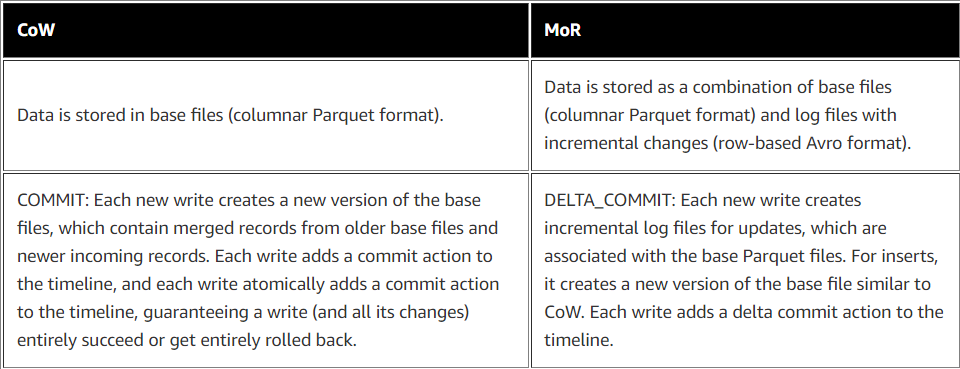
#### 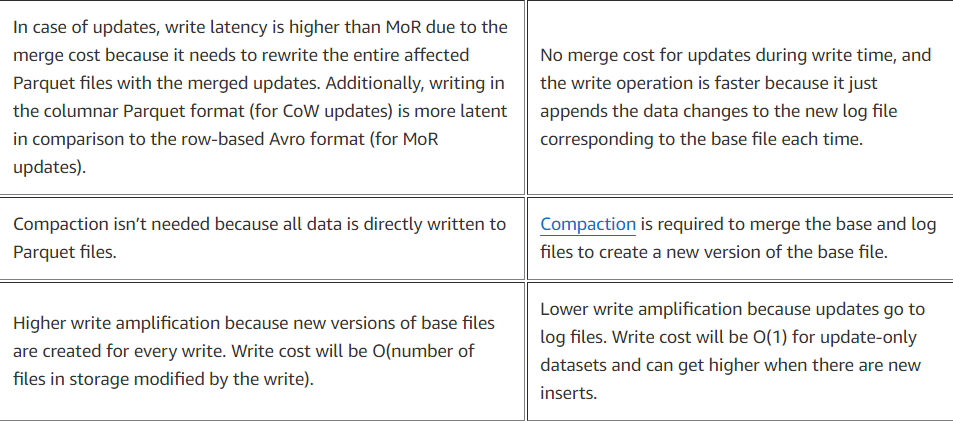
#### 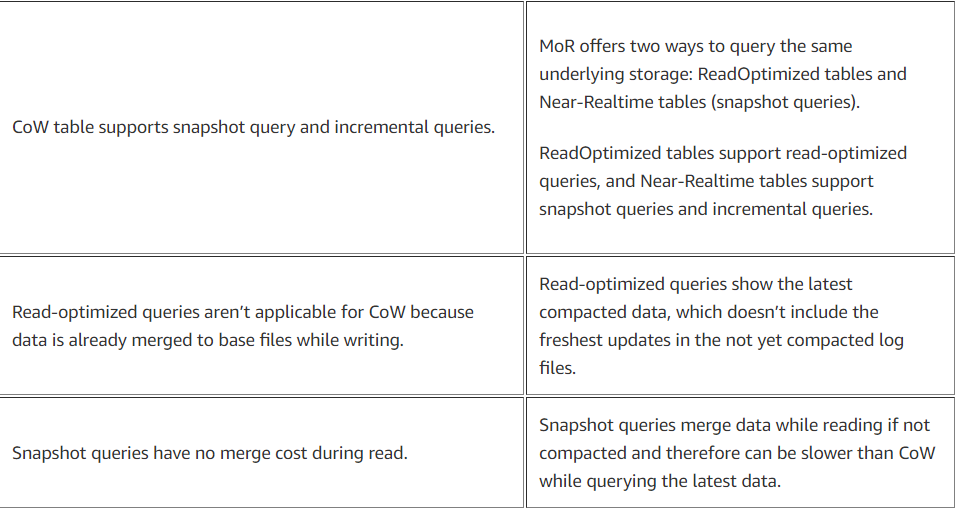


### MOR definition
The default table type is Copy-On-Write which is best suited for read-heavy workloads with modest writes. Copy-On-Write creates commit files with original data + the new changes during writing itself. While this increases latency on writes, this set up makes it more manageable for faster read.

For near real-time applications that mandate quick upserts, MERGE_ON_READ table type would be better suited. MOR table stores incoming upserts for each file group, onto a row based delta log (In Avro file format). This log is then merged with the existing Parquet file using a a compactor during reads.

## MOR IMPLEMENTATION

In [10]:
config = {
    "table_name": "hudi_mor_trips_table",
    "table_name_rt": "hudi_mor_trips_table_rt",
    "target": "s3://emrpocgigaforce/Output/hudi_data/hudi/hudi_mor/",
    "primary_key": "trip_id",
    "sort_key": "ts",
    "commits_to_retain": "2",
}

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [13]:
STORAGE_TYPE_OPT_KEY="hoodie.datasource.write.storage.type"
COMPACTION_INLINE_OPT_KEY="hoodie.compact.inline"
COMPACTION_MAX_DELTA_COMMITS_OPT_KEY="hoodie.compact.inline.max.delta.commits"

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [11]:
df_mor=create_json_df(spark, get_json_data(0, 2000000, dest))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [14]:
(df_mor.write.format(HUDI_FORMAT)
      .option(PRECOMBINE_FIELD_OPT_KEY,config["sort_key"])
      .option(RECORDKEY_FIELD_OPT_KEY, config["primary_key"])
      .option(TABLE_NAME, config['table_name'])
      .option(OPERATION_OPT_KEY, BULK_INSERT_OPERATION_OPT_VAL)
      .option(BULK_INSERT_PARALLELISM, 3)
      .option(S3_CONSISTENCY_CHECK, "true")
      .option(HIVE_TABLE_OPT_KEY,config['table_name'])
      .option(HIVE_SYNC_ENABLED_OPT_KEY,"true")
      .option(HIVE_PARTITION_EXTRACTOR_CLASS_OPT_KEY,NONPARTITION_EXTRACTOR_CLASS_OPT_VAL)
      .option(KEYGENERATOR_CLASS_OPT_KEY,NONPARTITIONED_KEYGENERATOR_CLASS_OPT_VAL)
      .option(STORAGE_TYPE_OPT_KEY,"MERGE_ON_READ")
      .option(COMPACTION_INLINE_OPT_KEY,"false")
      .option(COMPACTION_MAX_DELTA_COMMITS_OPT_KEY,"20")
      .mode("Overwrite")
      .save(config['target'])
)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [15]:
spark.sql("show tables").show(10,False)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------+-----------------------+-----------+
|namespace|tableName              |isTemporary|
+---------+-----------------------+-----------+
|default  |hudi_mor_trips_table_ro|false      |
|default  |hudi_mor_trips_table_rt|false      |
+---------+-----------------------+-----------+

In [16]:
spark.sql("show create table " + config['table_name'] + "_ro").show(20,False)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|createtab_stmt                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

In [17]:
spark.sql("show create table " + config['table_name'] + "_rt").show(20,False)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|createtab_stmt                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

In [18]:
df2_mor=spark.read.format(HUDI_FORMAT).load(config['target'] + "/*")


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [19]:
df2_mor.show(20,False)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------+----------------------+------------------+----------------------+----------------------------------------------------------------------+-------------+--------+-------+-----------------------+
|_hoodie_commit_time|_hoodie_commit_seqno  |_hoodie_record_key|_hoodie_partition_path|_hoodie_file_name                                                     |destination  |route_id|trip_id|ts                     |
+-------------------+----------------------+------------------+----------------------+----------------------------------------------------------------------+-------------+--------+-------+-----------------------+
|20230517042030442  |20230517042030442_1_1 |1000448           |                      |84afd4d0-aed4-4e04-9391-dbbc09be6f83-0_1-3-0_20230517042030442.parquet|Miami        |I       |1000448|2023-05-17 04:19:52.063|
|20230517042030442  |20230517042030442_1_3 |1000449           |                      |84afd4d0-aed4-4e04-9391-dbbc09be6f83-0_1-3-0_20230517042030442

In [20]:
spark.sql("select * from " + config['table_name'] + "_ro").show(20,False)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------+----------------------+------------------+----------------------+----------------------------------------------------------------------+-------------+--------+-------+-----------------------+
|_hoodie_commit_time|_hoodie_commit_seqno  |_hoodie_record_key|_hoodie_partition_path|_hoodie_file_name                                                     |destination  |route_id|trip_id|ts                     |
+-------------------+----------------------+------------------+----------------------+----------------------------------------------------------------------+-------------+--------+-------+-----------------------+
|20230517042030442  |20230517042030442_0_2 |0                 |                      |029ee7b5-7b1b-4a1e-a43d-0cdd91ce8866-0_0-2-0_20230517042030442.parquet|Seattle      |A       |0      |2023-05-17 04:19:52.063|
|20230517042030442  |20230517042030442_0_4 |1                 |                      |029ee7b5-7b1b-4a1e-a43d-0cdd91ce8866-0_0-2-0_20230517042030442

In [21]:
# Changing data for upsert
upsert_dest_mor= ["noida" for i in range (0,100)]
df3_mor=create_json_df(spark, get_json_data(1000000,100, upsert_dest_mor))
df3_mor.show(20,False)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------+--------+-------+-----------------------+
|destination|route_id|trip_id|ts                     |
+-----------+--------+-------+-----------------------+
|noida      |A       |1000000|2023-05-17 04:22:20.255|
|noida      |B       |1000001|2023-05-17 04:22:20.255|
|noida      |C       |1000002|2023-05-17 04:22:20.255|
|noida      |D       |1000003|2023-05-17 04:22:20.255|
|noida      |E       |1000004|2023-05-17 04:22:20.255|
|noida      |F       |1000005|2023-05-17 04:22:20.255|
|noida      |G       |1000006|2023-05-17 04:22:20.255|
|noida      |H       |1000007|2023-05-17 04:22:20.255|
|noida      |I       |1000008|2023-05-17 04:22:20.255|
|noida      |J       |1000009|2023-05-17 04:22:20.255|
|noida      |A       |1000010|2023-05-17 04:22:20.255|
|noida      |B       |1000011|2023-05-17 04:22:20.255|
|noida      |C       |1000012|2023-05-17 04:22:20.255|
|noida      |D       |1000013|2023-05-17 04:22:20.255|
|noida      |E       |1000014|2023-05-17 04:22:20.255|
|noida    

In [22]:
(df3_mor.write.format(HUDI_FORMAT)
      .option(PRECOMBINE_FIELD_OPT_KEY, config["sort_key"])
      .option(RECORDKEY_FIELD_OPT_KEY, config["primary_key"])
      .option(TABLE_NAME, config['table_name'])
      .option(OPERATION_OPT_KEY, UPSERT_OPERATION_OPT_VAL)
      .option(UPSERT_PARALLELISM, 3)
      .option(S3_CONSISTENCY_CHECK, "true")
      .option(HUDI_CLEANER_POLICY, KEEP_LATEST_COMMITS)
      .option(HUDI_COMMITS_RETAINED,config["commits_to_retain"])
      .option(HIVE_TABLE_OPT_KEY,config['table_name'])
      .option(HIVE_SYNC_ENABLED_OPT_KEY,"true")
      .option(HIVE_PARTITION_EXTRACTOR_CLASS_OPT_KEY,NONPARTITION_EXTRACTOR_CLASS_OPT_VAL)
      .option(KEYGENERATOR_CLASS_OPT_KEY,NONPARTITIONED_KEYGENERATOR_CLASS_OPT_VAL)  
      .option(STORAGE_TYPE_OPT_KEY, "MERGE_ON_READ")
      .option(COMPACTION_INLINE_OPT_KEY, "false")
      .option(COMPACTION_MAX_DELTA_COMMITS_OPT_KEY, "20")
      .mode("Append")
      .save(config['target']))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [23]:
df4_mor=spark.read.format(HUDI_FORMAT).load(config['target'] + "/*")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [25]:
# Modify the data
from pyspark.sql.functions import *
from pyspark.sql.functions import lit
from pyspark.sql.functions import when, col
df4_mor.filter(col("trip_id").between(1000000,1000100)).show(100,False)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------+-----------------------+------------------+----------------------+--------------------------------------+-----------+--------+-------+-----------------------+
|_hoodie_commit_time|_hoodie_commit_seqno   |_hoodie_record_key|_hoodie_partition_path|_hoodie_file_name                     |destination|route_id|trip_id|ts                     |
+-------------------+-----------------------+------------------+----------------------+--------------------------------------+-----------+--------+-------+-----------------------+
|20230517042222304  |20230517042222304_0_6  |1000000           |                      |029ee7b5-7b1b-4a1e-a43d-0cdd91ce8866-0|noida      |A       |1000000|2023-05-17 04:22:20.255|
|20230517042222304  |20230517042222304_0_96 |1000001           |                      |029ee7b5-7b1b-4a1e-a43d-0cdd91ce8866-0|noida      |B       |1000001|2023-05-17 04:22:20.255|
|20230517042222304  |20230517042222304_0_29 |1000002           |                      |029ee7b5-7b1b

In [26]:
# Inserting new data

insert_dest=["ghaziabad" for i in range(0,100)]
df5_mor=create_json_df(spark,get_json_data(2000000,100,insert_dest))
df5_mor.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------+--------+-------+--------------------+
|destination|route_id|trip_id|                  ts|
+-----------+--------+-------+--------------------+
|  ghaziabad|       A|2000000|2023-05-17 04:25:...|
|  ghaziabad|       B|2000001|2023-05-17 04:25:...|
|  ghaziabad|       C|2000002|2023-05-17 04:25:...|
|  ghaziabad|       D|2000003|2023-05-17 04:25:...|
|  ghaziabad|       E|2000004|2023-05-17 04:25:...|
|  ghaziabad|       F|2000005|2023-05-17 04:25:...|
|  ghaziabad|       G|2000006|2023-05-17 04:25:...|
|  ghaziabad|       H|2000007|2023-05-17 04:25:...|
|  ghaziabad|       I|2000008|2023-05-17 04:25:...|
|  ghaziabad|       J|2000009|2023-05-17 04:25:...|
|  ghaziabad|       A|2000010|2023-05-17 04:25:...|
|  ghaziabad|       B|2000011|2023-05-17 04:25:...|
|  ghaziabad|       C|2000012|2023-05-17 04:25:...|
|  ghaziabad|       D|2000013|2023-05-17 04:25:...|
|  ghaziabad|       E|2000014|2023-05-17 04:25:...|
|  ghaziabad|       F|2000015|2023-05-17 04:25:...|
|  ghaziabad

In [27]:
(df5_mor.write.format(HUDI_FORMAT)
      .option(PRECOMBINE_FIELD_OPT_KEY, config["sort_key"])
      .option(RECORDKEY_FIELD_OPT_KEY, config["primary_key"])
      .option(TABLE_NAME, config['table_name'])
      .option(OPERATION_OPT_KEY, UPSERT_OPERATION_OPT_VAL)
      .option(UPSERT_PARALLELISM, 3)
      .option(S3_CONSISTENCY_CHECK, "true")
      .option(HUDI_CLEANER_POLICY, KEEP_LATEST_COMMITS)
      .option(HUDI_COMMITS_RETAINED,config["commits_to_retain"])
      .option(HIVE_TABLE_OPT_KEY,config['table_name'])
      .option(HIVE_SYNC_ENABLED_OPT_KEY,"true")
      .option(HIVE_PARTITION_EXTRACTOR_CLASS_OPT_KEY,NONPARTITION_EXTRACTOR_CLASS_OPT_VAL)
      .option(KEYGENERATOR_CLASS_OPT_KEY,NONPARTITIONED_KEYGENERATOR_CLASS_OPT_VAL)  
      .option(STORAGE_TYPE_OPT_KEY, "MERGE_ON_READ")
      .option(COMPACTION_INLINE_OPT_KEY, "false")
      .option(COMPACTION_MAX_DELTA_COMMITS_OPT_KEY, "20")
      .mode("Append")
      .save(config['target']))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [28]:
df6_mor=spark.read.format(HUDI_FORMAT).load(config['target'] + "/*")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [29]:
df6_mor.filter(col("trip_id").between(2000000,2000100)).show(100,False)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------+--------------------------+------------------+----------------------+-------------------------------------------------------------------------+-----------+--------+-------+-----------------------+
|_hoodie_commit_time|_hoodie_commit_seqno      |_hoodie_record_key|_hoodie_partition_path|_hoodie_file_name                                                        |destination|route_id|trip_id|ts                     |
+-------------------+--------------------------+------------------+----------------------+-------------------------------------------------------------------------+-----------+--------+-------+-----------------------+
|20230517042558970  |20230517042558970_0_999552|2000078           |                      |84afd4d0-aed4-4e04-9391-dbbc09be6f83-0_0-99-127_20230517042558970.parquet|ghaziabad  |I       |2000078|2023-05-17 04:25:54.669|
|20230517042558970  |20230517042558970_0_999553|2000077           |                      |84afd4d0-aed4-4e04-9391-dbbc09be6f83-0

In [30]:
# read RO file as dataframe
# Read Optimized (RO) files: These files contain immutable data that is optimized for read-heavy workloads. 
# RO files are created as a result of compaction and contain a full snapshot of the data at the time of compaction. 
# RO files can be queried using standard SQL engines like Presto, Athena, and Spark SQL
# When a read query is executed against a Hudi MOR table, both RO and RT files are scanned to retrieve the latest data.
# RO files are used for historical data, while RT files are used for the latest changes

ro_df = spark.read.format("org.apache.hudi") \
    .option("hoodie.table.name", "hudi_mor_trips_table") \
    .option("hoodie.datasource.read.storage.type", "RO") \
    .load(config['target'] + "/*")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [31]:
ro_df.show(50,False)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------+----------------------+------------------+----------------------+-------------------------------------------------------------------------+-------------+--------+-------+-----------------------+
|_hoodie_commit_time|_hoodie_commit_seqno  |_hoodie_record_key|_hoodie_partition_path|_hoodie_file_name                                                        |destination  |route_id|trip_id|ts                     |
+-------------------+----------------------+------------------+----------------------+-------------------------------------------------------------------------+-------------+--------+-------+-----------------------+
|20230517042030442  |20230517042030442_1_1 |1000448           |                      |84afd4d0-aed4-4e04-9391-dbbc09be6f83-0_0-99-127_20230517042558970.parquet|Miami        |I       |1000448|2023-05-17 04:19:52.063|
|20230517042030442  |20230517042030442_1_3 |1000449           |                      |84afd4d0-aed4-4e04-9391-dbbc09be6f83-0_0-99-127_20

In [32]:
# read RO file as dataframe
# Realtime (RT) files: These files contain mutable data that is optimized for write-heavy workloads.
# RT files are written as new data is ingested into the Hudi dataset. 
# RT files are small and efficient, allowing for fast writes.

rt_df = spark.read.format("org.apache.hudi") \
    .option("hoodie.table.name", "hudi_mor_trips_table") \
    .option("hoodie.datasource.read.storage.type", "RT") \
    .load(config['target'] + "/*")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [33]:
rt_df.show(50,False)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------+----------------------+------------------+----------------------+-------------------------------------------------------------------------+-------------+--------+-------+-----------------------+
|_hoodie_commit_time|_hoodie_commit_seqno  |_hoodie_record_key|_hoodie_partition_path|_hoodie_file_name                                                        |destination  |route_id|trip_id|ts                     |
+-------------------+----------------------+------------------+----------------------+-------------------------------------------------------------------------+-------------+--------+-------+-----------------------+
|20230517042030442  |20230517042030442_1_1 |1000448           |                      |84afd4d0-aed4-4e04-9391-dbbc09be6f83-0_0-99-127_20230517042558970.parquet|Miami        |I       |1000448|2023-05-17 04:19:52.063|
|20230517042030442  |20230517042030442_1_3 |1000449           |                      |84afd4d0-aed4-4e04-9391-dbbc09be6f83-0_0-99-127_20

In [34]:
# check if the two dataframes are the same
diff_df = ro_df.exceptAll(rt_df)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [35]:
diff_df.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------+--------------------+------------------+----------------------+-----------------+-----------+--------+-------+---+
|_hoodie_commit_time|_hoodie_commit_seqno|_hoodie_record_key|_hoodie_partition_path|_hoodie_file_name|destination|route_id|trip_id| ts|
+-------------------+--------------------+------------------+----------------------+-----------------+-----------+--------+-------+---+
+-------------------+--------------------+------------------+----------------------+-----------------+-----------+--------+-------+---+

In [36]:
spark.sql("select distinct (_hoodie_commit_time) as commit_time from " + config['table_name'] + "_ro").show(20,False)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------------+
|commit_time      |
+-----------------+
|20230517042030442|
|20230517042558970|
+-----------------+

In [37]:
spark.sql("select distinct (_hoodie_commit_time) as commit_time from " + config['table_name'] + "_rt" + " order by commit_time desc").show(20,False)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------------+
|commit_time      |
+-----------------+
|20230517042558970|
|20230517042222304|
|20230517042030442|
+-----------------+

In [38]:
# Time travel in MOR  
# Selecting the particular commit  in case of both ro & rt
commit_ro=spark.sql("select distinct (_hoodie_commit_time) as commit_time from " + config['table_name'] + "_ro" + " order by commit_time desc").collect()
commit_rt=spark.sql("select distinct (_hoodie_commit_time) as commit_time from " + config['table_name'] + "_rt" + " order by commit_time desc").collect()


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [44]:
# selecting the particular commit  for which we want to rollback
commit_time_ro=commit_ro[0] #previous commit 
commit_time_rt=commit_ro[0] # previous commit

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [49]:
ro_df_filtered_commit=ro_df.filter(f"_hoodie_commit_time < 20230517042558970 ") 

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [50]:
ro_df_filtered_commit.show(20,False)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------+----------------------+------------------+----------------------+-------------------------------------------------------------------------+-------------+--------+-------+-----------------------+
|_hoodie_commit_time|_hoodie_commit_seqno  |_hoodie_record_key|_hoodie_partition_path|_hoodie_file_name                                                        |destination  |route_id|trip_id|ts                     |
+-------------------+----------------------+------------------+----------------------+-------------------------------------------------------------------------+-------------+--------+-------+-----------------------+
|20230517042030442  |20230517042030442_1_1 |1000448           |                      |84afd4d0-aed4-4e04-9391-dbbc09be6f83-0_0-99-127_20230517042558970.parquet|Miami        |I       |1000448|2023-05-17 04:19:52.063|
|20230517042030442  |20230517042030442_1_3 |1000449           |                      |84afd4d0-aed4-4e04-9391-dbbc09be6f83-0_0-99-127_20

In [51]:
rt_df_filtered_commit=rt_df.filter(f"_hoodie_commit_time < 20230517042558970 ") 

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [55]:
rt_df_filtered_commit.select(col('_hoodie_commit_time')).distinct().show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------+
|_hoodie_commit_time|
+-------------------+
|  20230517042030442|
|  20230517042222304|
+-------------------+

In [59]:
rt_df_filtered_commit.select(col('_hoodie_commit_time')).distinct().count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

2

In [46]:
commit_ro[0]

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Row(commit_time='20230517042558970')

In [41]:
commit_rt[-2]

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Row(commit_time='20230517042222304')

In [ ]:
df7_mor=df6_mor.filter(col("trip_id").between(2000050,2000100))
(df7_mor.write.format(HUDI_FORMAT)
      .option(PRECOMBINE_FIELD_OPT_KEY,config["sort_key"])
      .option(RECORDKEY_FIELD_OPT_KEY, config["primary_key"])
      .option(TABLE_NAME, config['table_name'])
      .option(OPERATION_OPT_KEY, BULK_INSERT_OPERATION_OPT_VAL)
      .option(BULK_INSERT_PARALLELISM, 3)
      .option(S3_CONSISTENCY_CHECK, "true")
      .option(HIVE_TABLE_OPT_KEY,config['table_name'])
      .option(HIVE_SYNC_ENABLED_OPT_KEY,"true")
      .option(HIVE_PARTITION_EXTRACTOR_CLASS_OPT_KEY,NONPARTITION_EXTRACTOR_CLASS_OPT_VAL)
      .option(KEYGENERATOR_CLASS_OPT_KEY,NONPARTITIONED_KEYGENERATOR_CLASS_OPT_VAL)
      .option(STORAGE_TYPE_OPT_KEY,"MERGE_ON_READ")
      .option(COMPACTION_INLINE_OPT_KEY,"false")
      .option(COMPACTION_MAX_DELTA_COMMITS_OPT_KEY,"20")
      .option(PAYLOAD_CLASS_OPT_KEY,EMPTY_PAYLOAD_CLASS_OPT_VAL)  # deleting the record
      .mode("Append")
      .save(config['target'])
)

#### Time travel 
Used to query previous commit with incremental and point in time queries 
This previous commit can be used for incremental queries 


In [ ]:
commits=spark.sql("select distinct(_hoodie_commit_time)  from hudi_trips_table order by _hoodie_commit_time").collect()
print("commits: ")
for i in commits:
    print(i)

In [ ]:
commits[-3]

In [ ]:
# incrementally query data
beginTime=commits[-3]
incViewDF = spark.read.format(HUDI_FORMAT) \
                   .option(VIEW_TYPE_OPT_KEY, VIEW_TYPE_INCREMENTAL_OPT_VAL) \
                   .option(BEGIN_INSTANTTIME_OPT_KEY, beginTime) \
                   .load(config["target"]+) 

In [ ]:
# Load Data
df8=spark.read.format(HUDI_FORMAT).load(config["target"]+"/*")

In [ ]:
df8.count()

In [ ]:
df8.show()